Kaggle Notebook: https://www.kaggle.com/code/nguyenquanglinh0109/lung-segmentation

# 0. Paper

Phương pháp: + segmentation trên bộ lung (704 ảnh)  
             + phân loại trên bộ ảnh còn lại  
Dữ liệu: 2 bộ bên  
Preprocessing: Z-score normalization  
Mô hình: pytorch  
    - Lung Segmentation: pytorch (lr=1e-3, dropout=0.2, momentum=0.9, batch=32, 50 epochs, early_stopping=5)  
    - Nine CNN:   
        + 80-20 (5cv 20% của training-80 được sử dụng để cv)  
        + shallow networks (MobileNetv2, SqueezeNet and ResNet18)  
        +  six deep networks (Inceptionv3, ResNet 50, ResNet101, CheXNet,VGG19 and DenseNet201  
        + 
        

 The networks were implemented using PyTorch library
 with Python 3.7 on Intel R Xeon R CPU E5-2697 v4 @
 2,30GHz and 64 GB RAM, with a 16 GB NVIDIA GeForce
 GTX1080 GPU. Both the U-Net models were trained using
 Stochastic Gradient Descent (SGD) with momentum opti
mizer with learning rate, 
10 3, dropout rate 
momentum update, 
0.2,
 09, mini-batch size of 32 images
 with 50 back propagation epochs; early stopping criterion of
 5 maximum epochs when no improvement in validation loss
 is seen.

# 1. Thư viện

In [24]:
!pip install -U tensorflow keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 83.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: 

In [4]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.applications import VGG19, InceptionV3, ResNet50, DenseNet201, densenet, resnet
from tensorflow.keras.models import load_model


In [4]:
print(len(os.listdir('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal')))
print(len(os.listdir('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis')))

3500
700


# 2. About the dataset

In [8]:
DIR = "/kaggle/input/chest-xray-masks-and-labels/"

lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))


In [9]:
related_paths = defaultdict(list)
for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

In [12]:
paths_df.shape

(704, 2)

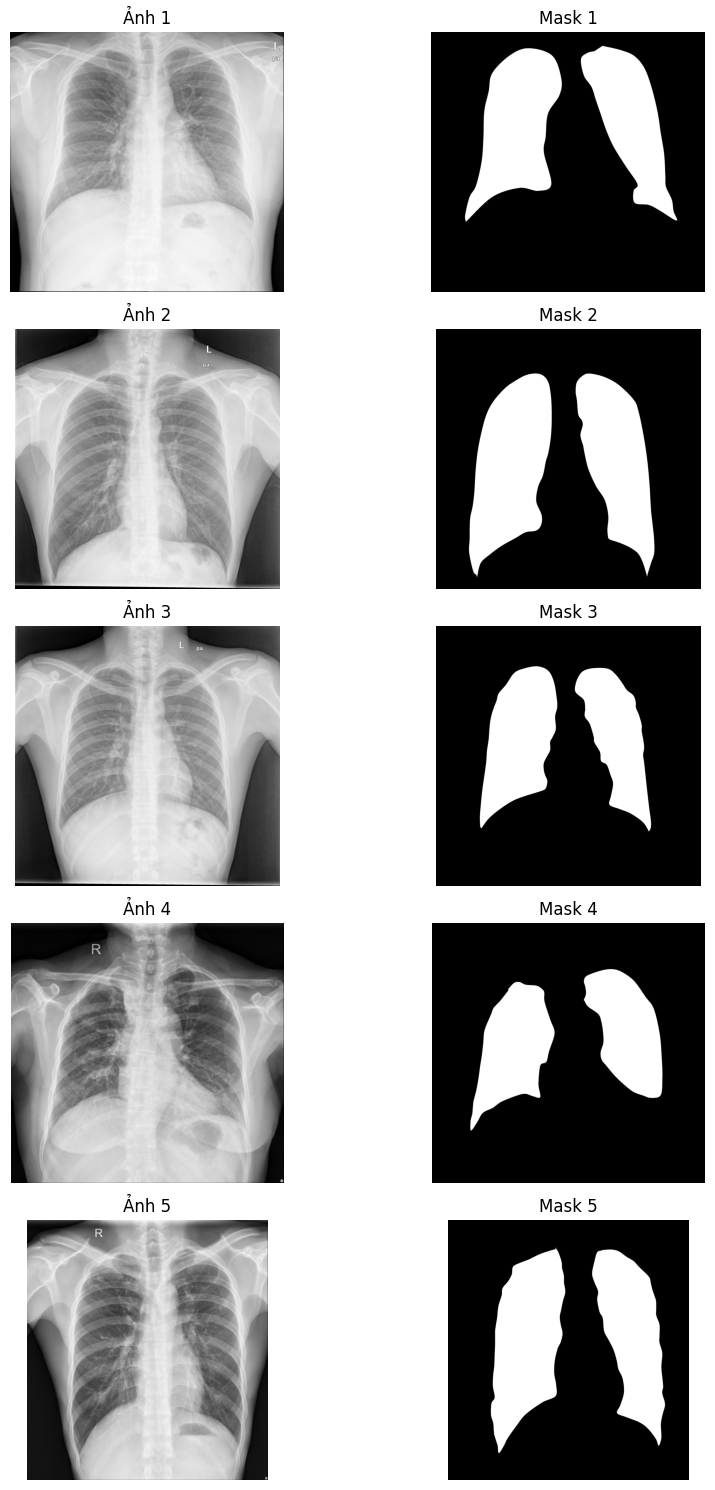

In [5]:
import cv2
import matplotlib.pyplot as plt

num_samples = 5  # Số lượng ảnh muốn hiển thị
fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))  # Tạo lưới subplot

for i in range(num_samples):
    img_path = paths_df["image_path"][i]
    mask_path = paths_df["mask_path"][i]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh X-ray (grayscale)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Đọc mask (grayscale)

    # Hiển thị ảnh gốc
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].axis("off")
    axes[i, 0].set_title(f"Ảnh {i+1}")

    # Hiển thị mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis("off")
    axes[i, 1].set_title(f"Mask {i+1}")

plt.tight_layout()  
plt.show()


# 3. Prepare the data

In [ ]:
import tensorflow as tf

IMG_SIZE = (256, 256)
BATCH_SIZE = 32

def parse_image(image_path, mask_path):
    """Đọc ảnh và mask từ đường dẫn, resize và chuẩn hóa"""
    # Đọc ảnh
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Đọc ảnh grayscale (1 kênh)
    image = tf.image.resize(image, IMG_SIZE) / 255.0  # Resize & chuẩn hóa

    # Đọc mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # Đọc mask grayscale
    mask = tf.image.resize(mask, IMG_SIZE) / 255.0 # Resize
 

    return image, mask

image_paths = tf.convert_to_tensor(paths_df.image_path.values, dtype=tf.string)
mask_paths = tf.convert_to_tensor(paths_df.mask_path.values, dtype=tf.string)

# Tạo Dataset và xáo trộn trước khi chia
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.shuffle(len(image_paths), reshuffle_each_iteration=False)

# Xác định số lượng mẫu cho từng tập
total_size = len(image_paths)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)  # 10% cho validation
test_size = total_size - train_size - val_size  # 10% còn lại cho test

# Chia tập dữ liệu
train_dataset = dataset.take(train_size).shuffle(train_size)
val_test_dataset = dataset.skip(train_size)  # Lấy phần còn lại (validation + test)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Áp dụng tiền xử lý, batching và prefetch cho từng tập
train_dataset = (train_dataset
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (val_dataset
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (test_dataset
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


# 4. Train Model

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Hàm tính IoU
def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)
    
def unet_model(input_shape=(256, 256, 1)):
    inputs = keras.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = keras.Model(inputs, outputs)
    return model

# Tạo model
model = unet_model()

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])


early_stopping = EarlyStopping(
    monitor='val_loss',  # Theo dõi giá trị loss trên tập validation
    patience=5,          # Số epochs không cải thiện trước khi dừng
    restore_best_weights=True  # Khôi phục trọng số tốt nhất
)

# Huấn luyện mô hình
model.fit(train_dataset, validation_data=val_dataset, epochs=30, callbacks=[early_stopping])


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6591 - dice_coefficient: 0.2734 - iou: 0.1624 - loss: 8.9516 - val_accuracy: 0.7402 - val_dice_coefficient: 0.3103 - val_iou: 0.1837 - val_loss: 0.6103
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7456 - dice_coefficient: 0.2762 - iou: 0.1613 - loss: 0.5994 - val_accuracy: 0.7402 - val_dice_coefficient: 0.3311 - val_iou: 0.1984 - val_loss: 0.5123
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7488 - dice_coefficient: 0.3260 - iou: 0.1948 - loss: 0.5164 - val_accuracy: 0.7402 - val_dice_coefficient: 0.3790 - val_iou: 0.2338 - val_loss: 0.4351
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7466 - dice_coefficient: 0.3840 - iou: 0.2380 - loss: 0.4233 - val_accuracy: 0.8457 - val_dice_coefficient: 0.5584 - val_iou: 0.3874 - val_loss: 0.3855
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.7728 - dice_coefficient: 0.4847 - iou: 0.3209 - loss: 0.4063 - val_accur

# 5. Evaluate Model

In [23]:
model.evaluate(test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9805 - dice_coefficient: 0.9434 - iou: 0.8928 - loss: 0.0539


[0.054159991443157196,
 0.9797388911247253,
 0.9411296248435974,
 0.8888471722602844]

In [14]:
segment_model = load_model('/kaggle/input/lung_segmentation/tensorflow2/default/1/unet_model.h5')
segment_model.evaluate(test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9782 - loss: 0.0528 


[0.05481922999024391, 0.9772265553474426]

In [15]:
# import numpy as np
# import tensorflow.keras.backend as K

# # Hàm tính Dice Coefficient
# def dice_coefficient(y_true, y_pred, smooth=1e-6):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# # Hàm tính IoU
# def iou(y_true, y_pred, smooth=1e-6):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
#     return (intersection + smooth) / (union + smooth)

# # Dự đoán trên tập test
# y_pred = segment_model.predict(test_dataset)

# # Chuyển về nhị phân (0 hoặc 1) nếu cần
# y_pred_bin = (y_pred > 0.5).astype(np.float32)

# # Lấy ground truth từ test dataset
# y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# # Tính Dice Score và IoU trung bình
# dice_score = dice_coefficient(y_true, y_pred_bin)
# iou_score = iou(y_true, y_pred_bin)

# print(f"Dice Score: {K.eval(dice_score):.4f}")
# print(f"IoU: {K.eval(iou_score):.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 729ms/step
Dice Score: 0.9575
IoU: 0.9186


In [5]:
DIR = "/kaggle/input/chest-xray-masks-and-labels/"

lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/test/*.png"))
# mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))
len(lung_image_paths)

96

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


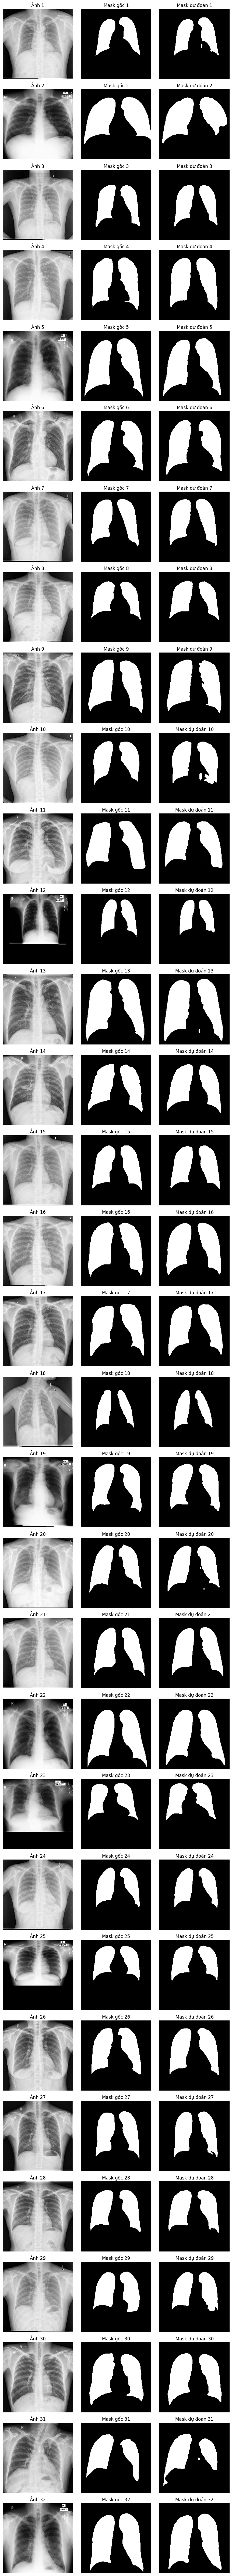

In [22]:
import matplotlib.pyplot as plt

for test_images, test_masks in test_dataset.take(1):  # Lấy 1 batch ảnh test
    pred_masks = model.predict(test_images)
    pred_masks = (pred_masks > 0.5).astype("uint8")  # Binarize mask

    batch_size = test_images.shape[0]  # Số lượng ảnh trong batch

    plt.figure(figsize=(9, batch_size * 3))  # Điều chỉnh kích thước hiển thị

    for i in range(batch_size):  
        # Ảnh gốc
        plt.subplot(batch_size, 3, 3 * i + 1)  
        plt.imshow(tf.squeeze(test_images[i]), cmap="gray")
        plt.axis("off")
        plt.title(f"Ảnh {i+1}")

        # Mask gốc
        plt.subplot(batch_size, 3, 3 * i + 2)  
        plt.imshow(tf.squeeze(test_masks[i]), cmap="gray")
        plt.axis("off")
        plt.title(f"Mặt nạ gốc {i+1}")

        # Mask dự đoán
        plt.subplot(batch_size, 3, 3 * i + 3)  
        plt.imshow(tf.squeeze(pred_masks[i]), cmap="gray")
        plt.axis("off")
        plt.title(f"Mặt nạ dự đoán {i+1}")

    plt.tight_layout()  # Căn chỉnh khoảng cách giữa các ảnh
    plt.show()


In [21]:
model.save("unet_model.h5")  # Lưu dưới dạng HDF5
